# 2021/06/28

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, UpSampling2D, Conv2DTranspose, ConvLSTM2D

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
### Pytorch code
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        print(x.shape)
        x = self.conv(x)
        print(x.shape)
        return x

torch.Size([2, 1, 10, 3])
torch.Size([2, 4, 10, 3])


In [3]:
class double_conv(tf.keras.layers.Layer):
    def __init__(self, out_ch):
        super(double_conv, self).__init__()
        self.conv = Sequential([
            Conv2D(filters=out_ch, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            Conv2D(filters=out_ch, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU()
        ])
    
    def call(self, x):
    #   print(x.shape)
      x = self.conv(x)
    #   print(x.shape)
      return x

In [ ]:
model = double_conv(4)
x = tf.zeros([2, 3, 10, 1], tf.float32)
pred = model(x)

(2, 3, 10, 1)
(2, 3, 10, 4)


In [ ]:
### pytorch code
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

In [4]:
class inconv(tf.keras.layers.Layer):
  def __init__(self, out_ch):
    super(inconv, self).__init__()
    self.conv = double_conv(out_ch)

  def call(self, x):
    x = self.conv(x)
    return x

model = inconv(4)
x = tf.zeros([2, 3, 10, 1], tf.float32)
pred = model(x)

In [ ]:
### pytorch code
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

In [5]:
class down(tf.keras.layers.Layer):
    def __init__(self, out_ch):
        super(down, self).__init__()
        self.mpconv = Sequential([
            MaxPool2D(pool_size=2),
            double_conv(out_ch)
        ])

    def call(self, x):
        # print(x.shape)
        x = self.mpconv(x)
        # print(x.shape)
        return x

model = down(4)
x = tf.zeros([2, 4, 10, 1], tf.float32)
pred = model(x)

In [ ]:
### pytorch code
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        print(x1.shape)
        x1 = self.up(x1)
        print(x1.shape)
        ### encoder의 feature map과 decoder의 feature map을 모두 사용하기 위해 둘의 shape를 맞춰주는 코드
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        print(diffX, diffY)
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        ###
        x = torch.cat([x2, x1], dim=1)
        print("x:", x.shape)
        x = self.conv(x)
        print("x:", x.shape)
        return x

In [ ]:
x = torch.zeros(1, 1, 10, 3, dtype=torch.float)
y = torch.zeros(1, 1, 20, 6, dtype=torch.float)
model = up(2, 1, bilinear=False)
pred = model(x, y)

torch.Size([1, 1, 10, 3])
torch.Size([1, 1, 20, 6])
0 0
x: torch.Size([1, 2, 20, 6])
x: torch.Size([1, 1, 20, 6])


### up 클래스 변환
- 아래의 call 메서드를 보면, 패딩을 주는 부분이 있는데 TF와 Pytorch의 패딩 옵션을 주는 방법이 약간 다르다.  
- Pytorch의 경우 아래와 같이 패딩을 줄 위치를 입력한다.  
Pytorch: 
```
x2 = F.pad(x2, (diffX // 2, int(diffX / 2), diffY // 2, int(diffY / 2)))
```
- TF의 경우 아래와 같이 옵션을 입력한다.
- 자세히 보면, 리스트의 인덱스에 해당하는 차원의 윗부분에는 두번째 차원 리스트의 첫번째 element만큼의 줄에 해당하는 패딩을, 아랫부분에는 두번째 element만큼의 줄에 해당하는 패딩을 추가한다.
- 예를 들어 리스트의 0번째 element인 [0, 0]은 0번째 차원에 위 아래로 패딩을 0줄, 즉, 패딩을 주지 않겠다는 것을 의미하고, 리스트의 첫번째 element인 [diffX // 2, int(diffX / 2)]는 첫번째 차원의 윗부분은 diffX // 2 줄의 패딩을, 아래부분은 int(diffX / 2) 줄의 패딩을 추가한다는 것을 의미한다.  
Tensorflow: 
 ```
 paddings = [[0, 0],
             [diffX // 2, int(diffX / 2)],
             [diffY // 2, int(diffY / 2)],
             [0, 0]]
 x_enc = tf.pad(x_enc, paddings=paddings)
 ```

In [29]:
class up(tf.keras.layers.Layer):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = UpSampling2D(size=(2, 2))
        else:
            self.up = Conv2DTranspose(filters=in_ch//2, kernel_size=2, strides=2)

        self.conv = double_conv(out_ch)
    
    def call(self, x_dec, x_enc):
        x_dec = self.up(x_dec)
        print(x_dec.shape)
        diffX = x_dec.shape[1] - x_enc.shape[1]
        diffY = x_dec.shape[2] - x_enc.shape[2]
        print(diffX, diffY)
        paddings = [[0, 0],
                    [diffX // 2, int(diffX / 2)],
                    [diffY // 2, int(diffY / 2)],
                    [0, 0]]
        x_enc = tf.pad(x_enc, paddings=paddings)
        print(x_enc.shape, x_enc.dtype, x_dec.dtype)
        x = tf.concat([x_enc, x_dec], axis=-1)
        print(x_enc.shape, x_dec.shape)
        print(x.shape)
        x = self.conv(x)
        print(x.shape)
        return x

In [30]:
model = up(2, 2)
x = tf.zeros([2, 3, 10, 3], tf.float32)
y = tf.zeros([2, 4, 16, 3], tf.float32)
pred = model(x, y)

(2, 6, 20, 3)
2 4
(2, 6, 20, 3) <dtype: 'float32'> <dtype: 'float32'>
(2, 6, 20, 3) (2, 6, 20, 3)
(2, 6, 20, 6)
(2, 6, 20, 2)


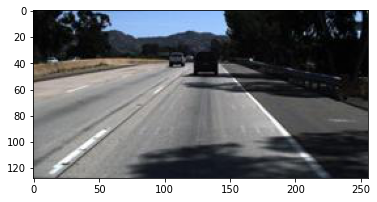

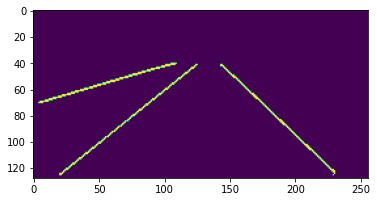

(1, 128, 256, 3)
(1, 128, 256)
(1, 128, 256, 3) (1, 128, 256) <dtype: 'float32'> <dtype: 'float32'>
(1, 256, 512, 3)
128 256
(1, 256, 512, 3) <dtype: 'float32'> <dtype: 'float32'>
(1, 256, 512, 3) (1, 256, 512, 3)
(1, 256, 512, 6)
(1, 256, 512, 2)
(1, 256, 512, 2)


In [31]:
test_image_dir = "/content/drive/MyDrive/2_master/1_Github/Lane_detection/LaneDetectionCode/data/testset/image/1_1.jpg"
test_label_dir = "/content/drive/MyDrive/2_master/1_Github/Lane_detection/LaneDetectionCode/data/testset/truth/1_13.jpg"
data = Image.open(test_image_dir)
label = Image.open(test_label_dir)

ndata = np.array(data)
plt.imshow(ndata)
plt.show()
ndata = ndata.astype(np.float32)
ndata = ndata[np.newaxis, ...]
nlabel = np.array(label, dtype=np.float32)
plt.imshow(nlabel)
plt.show()
nlabel = nlabel[np.newaxis, ...]
print(ndata.shape)
print(nlabel.shape)

test_ds = tf.data.Dataset.from_tensor_slices((ndata, nlabel))
test_ds = test_ds.batch(1)

### up class test
for img, label in test_ds:
    print(img.shape, label.shape, img.dtype, label.dtype)
    pred = model(img, img)
    print(pred.shape)

### outconv 클래스 변환

In [ ]:
### Pytorch code
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [16]:
### TF code
class outconv(tf.keras.layers.Layer):
    def __init__(self, out_ch):
        super(outconv, self).__init__()
        self.conv = Conv2D(filters=out_ch, kernel_size=1)

    def call(self, x):
        print("Shape before conv:", x.shape)
        x = self.conv(x)
        print("Shape after  conv:", x.shape)
        return x

In [33]:
outconvModel = outconv(2)

### outconv class test
for img, label in test_ds:
    print(img.shape, label.shape)
    pred = outconvModel(img)
    print("Pred shape:", pred.shape)

(1, 128, 256, 3) (1, 128, 256)
Shape before conv: (1, 128, 256, 3)
Shape after  conv: (1, 128, 256, 2)
Pred shape: (1, 128, 256, 2)


### ConvLSTM2D 클래스 생성

In [ ]:
class ConvLSTM(tf.keras.layers.Layer):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()
        self.convlstm = ConvLSTM2D(filters)


In [40]:
steps = 5
height = 256
width = 128
input_channels = 3
output_channels = 6

inputs = tf.keras.Input(shape=(steps, height, width, input_channels))
print(inputs.shape)
layer = tf.keras.layers.ConvLSTM2D(filters=output_channels, kernel_size=3, units=3)
# for img, label in test_ds:
#     print(img.shape, label.shape,type(img), type(label))
#     # pred = outconvModel(img)

#     pred = layer(img)
#     print("Pred shape:", pred.shape)
outputs = layer(inputs)
print(outputs.shape)

(None, 5, 256, 128, 3)


TypeError: ignored